In [26]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from time import time
from matplotlib import image
from torchvision import transforms, datasets, models
import time
import torch
import torch.utils.data as data

import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
### Configurations
data_dir = 'input/data/train'
img_dir = f'{data_dir}/images'
df_path = f'{data_dir}/new_train.csv'
gdf_path = f'{data_dir}/gray_train.csv'
model_path = f'{data_dir}/models'
gs_img_dir = f'{data_dir}/gray_scale_images'

In [28]:
df = pd.read_csv(df_path)
df

Unnamed: 0            gender race age isWearing  \
0               0  female Asian 45 incorrectly wearing   
1               1              female Asian 45 wearing   
2               2              female Asian 45 wearing   
3               3              female Asian 45 wearing   
4               4              female Asian 45 wearing   
...           ...                                  ...   
18894       18894                male Asian 19 wearing   
18895       18895                male Asian 19 wearing   
18896       18896                male Asian 19 wearing   
18897       18897                male Asian 19 wearing   
18898       18898            male Asian 19 not wearing   

                                                abs_path  class  
0      input/data/train/images/000001_female_Asian_45...     10  
1      input/data/train/images/000001_female_Asian_45...      4  
2      input/data/train/images/000001_female_Asian_45...      4  
3      input/data/train/images/000001_female_Asian_45...      4  
4      input/data/train/images/000001_female_Asian_45...      4  
...                                                  ...    ...  
18894  input/data/train/images/006959_male_Asian_19/m...      0  
18895  input/data/train/images/006959_male_Asian_19/m...      0  
18896  input/data/train/images/006959_male_Asian_19/m...      0  
18897  input/data/train/images/006959_male_Asian_19/m...      0  
18898  input/data/train/images/006959_male_Asian_19/n...     12  

[18899 rows x 4 columns]

# Model

In [64]:
class BaseDataset(data.Dataset):

    def __init__(self, transform=None):
        
        self.X = df['abs_path']
        self.y = df['class']
        self.transform = transform

    def set_transform(self, transform):
        
        self.transform = transform

    def __getitem__(self, index):

        image = Image.open(self.X[index])
        label = self.y[index]
        
        # 이미지를 Augmentation 시킵니다.
        image_transform = self.transform(image=np.array(image))['image']
#         image_transform = self.transform(image)
        return image_transform, label

    def __len__(self):
        return len(self.X)

# Transformers

In [65]:
from albumentations import *
from albumentations.pytorch import ToTensorV2


def get_transforms(need=('train', 'val'), img_size=(512, 384), mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)):
    """
    train 혹은 validation의 augmentation 함수를 정의합니다. train은 데이터에 많은 변형을 주어야하지만, validation에는 최소한의 전처리만 주어져야합니다.
    
    Args:
        need: 'train', 혹은 'val' 혹은 둘 다에 대한 augmentation 함수를 얻을 건지에 대한 옵션입니다.
        img_size: Augmentation 이후 얻을 이미지 사이즈입니다.
        mean: 이미지를 Normalize할 때 사용될 RGB 평균값입니다.
        std: 이미지를 Normalize할 때 사용될 RGB 표준편차입니다.

    Returns:
        transformations: Augmentation 함수들이 저장된 dictionary 입니다. transformations['train']은 train 데이터에 대한 augmentation 함수가 있습니다.
    """
    transformations = {}
    if 'train' in need:
        transformations['train'] = Compose([
            Resize(img_size[0], img_size[1], p=1.0),
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            GaussNoise(p=0.5),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    if 'val' in need:
        transformations['val'] = Compose([
            Resize(img_size[0], img_size[1]),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    return transformations

### 2nd transformer

In [66]:
mean = [0.56019068, 0.52409788, 0.50145447]
std = [0.23318342, 0.24299835, 0.24567397]

In [62]:
from torchvision import transforms

transforms_train = transforms.Compose([
    transforms.Resize((512, 384)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean, std) # normalization
])

transforms_val = transforms.Compose([
    transforms.Resize((512, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Dataset

In [67]:
# 정의한 Augmentation 함수와 Dataset 클래스 객체를 생성합니다.
transform = get_transforms(mean=mean, std=std)

dataset = BaseDataset()

# train dataset과 validation dataset을 8:2 비율로 나눕니다.
n_val = int(len(dataset) * 0.2)
n_train = len(dataset) - n_val
train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])

# 각 dataset에 augmentation 함수를 설정합니다.
train_dataset.dataset.set_transform(transform['train'])
val_dataset.dataset.set_transform(transform['val'])

### second dataset

In [8]:
dataset = BaseDataset()

# train dataset과 validation dataset을 8:2 비율로 나눕니다.
n_val = int(len(dataset) * 0.2)
n_train = len(dataset) - n_val
train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])

# 각 dataset에 augmentation 함수를 설정합니다.
train_dataset.dataset.set_transform(transforms_train)
val_dataset.dataset.set_transform(transforms_val)

# DataLoader

In [68]:
# training dataloader은 데이터를 섞어주어야 합니다. (shuffle=True)
train_loader = data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=True
)

val_loader = data.DataLoader(
    val_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=False
)

# Convert to GPU

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
device

device(type='cuda', index=0)

# Model

In [70]:
model = models.resnet152(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 18)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### 강의 transformer (epoch = 8) and simple transformer (epohc = 7)
### resnet152 (epoch = 7, 11)

In [71]:
import time

num_epochs = 7
start_time = time.time()

for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Validation Phase """
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_dataset)
        epoch_acc = running_corrects / len(val_dataset) * 100.
        print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

[Train #0] Loss: 0.9708 Acc: 70.9325% Time: 421.7154s
[Validation #0] Loss: 0.3512 Acc: 89.4417% Time: 461.8378s
[Train #1] Loss: 0.2654 Acc: 91.6005% Time: 883.7458s
[Validation #1] Loss: 0.1728 Acc: 94.1254% Time: 924.0056s
[Train #2] Loss: 0.1211 Acc: 96.4087% Time: 1345.9285s
[Validation #2] Loss: 0.1667 Acc: 94.1254% Time: 1386.0680s
[Train #3] Loss: 0.0582 Acc: 98.7368% Time: 1807.8820s
[Validation #3] Loss: 0.0801 Acc: 97.4596% Time: 1848.1442s
[Train #4] Loss: 0.0345 Acc: 99.3651% Time: 2270.1309s
[Validation #4] Loss: 0.0554 Acc: 98.3329% Time: 2310.2982s
[Train #5] Loss: 0.0264 Acc: 99.4907% Time: 2732.2636s
[Validation #5] Loss: 0.0470 Acc: 98.6769% Time: 2772.4668s
[Train #6] Loss: 0.0144 Acc: 99.8677% Time: 3194.1802s
[Validation #6] Loss: 0.0327 Acc: 98.9944% Time: 3234.4507s


In [73]:
# save the model
torch.save(model.state_dict(), os.path.join(model_path, 'model_resnet152_transform.pth'))

# Test the model

In [74]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, ToTensor, Normalize

In [75]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

In [76]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [77]:
from torchvision import transforms
import torchvision

# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=mean, std=std),
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')

### Test with eval dataset

In [78]:
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()

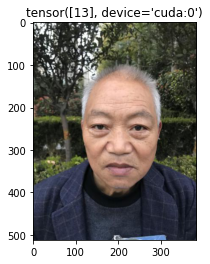

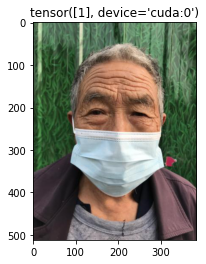

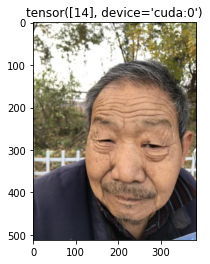

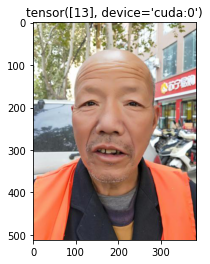

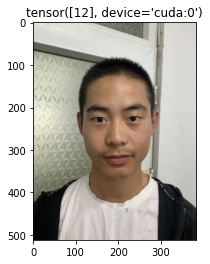

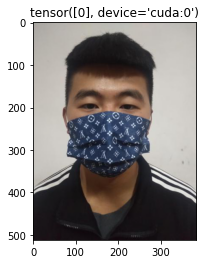

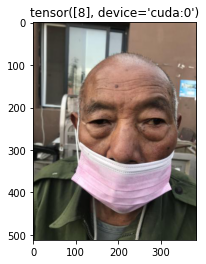

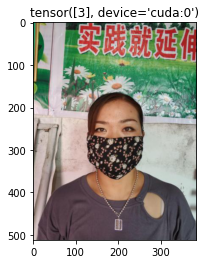

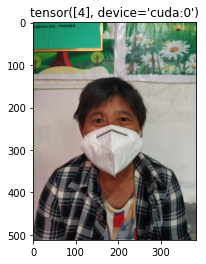

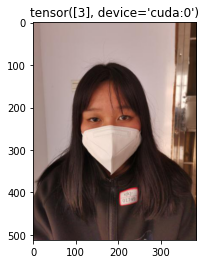

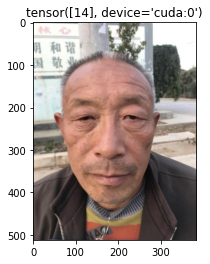

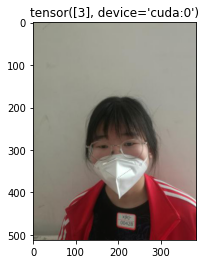

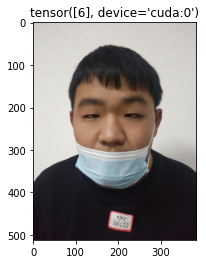

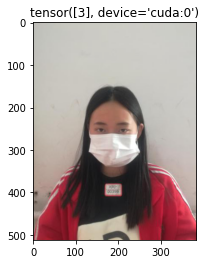

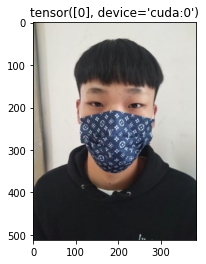

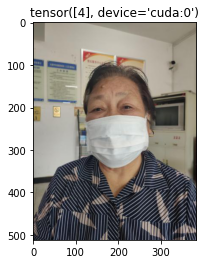

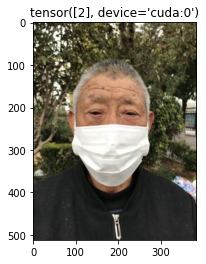

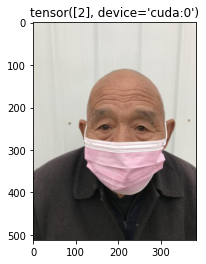

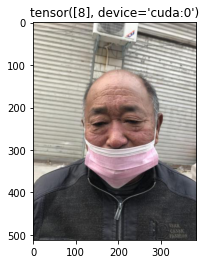

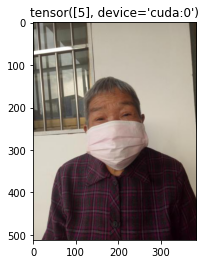

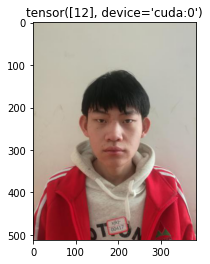

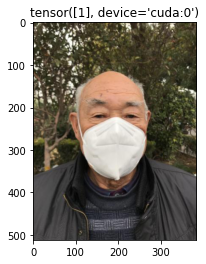

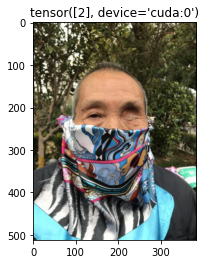

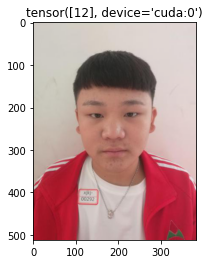

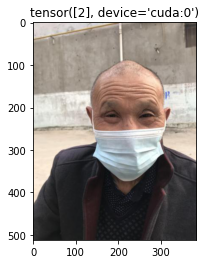

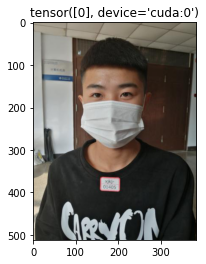

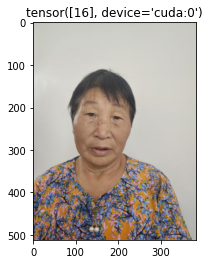

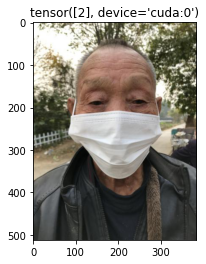

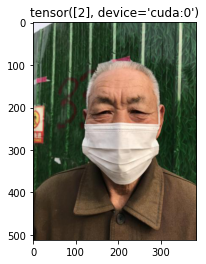

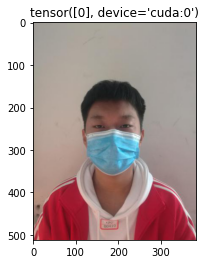

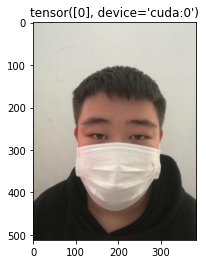

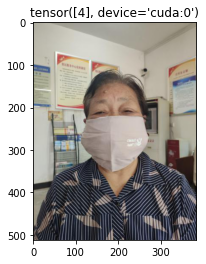

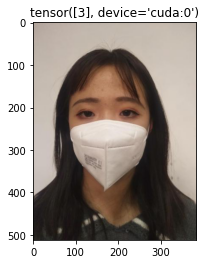

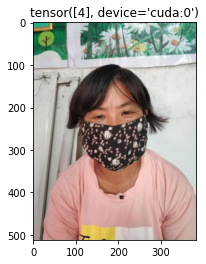

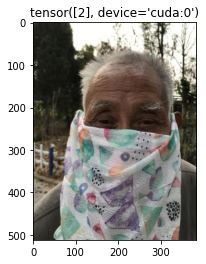

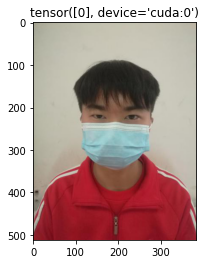

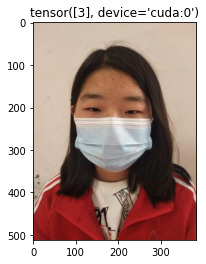

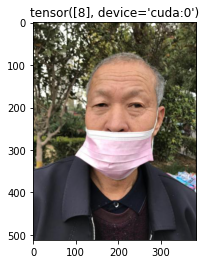

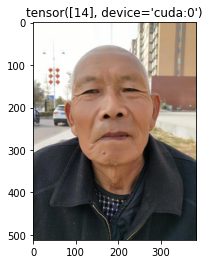

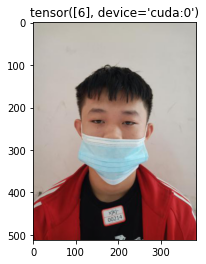

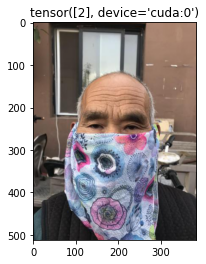

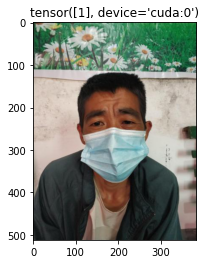

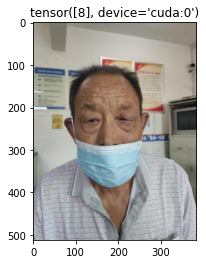

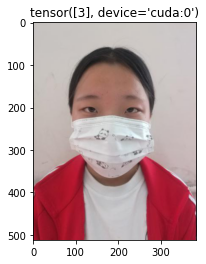

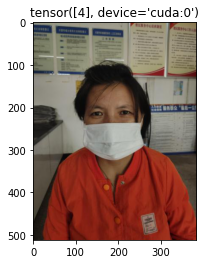

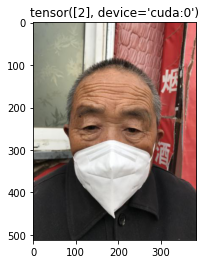

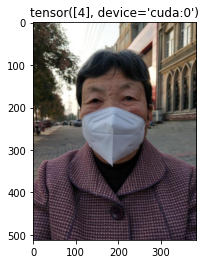

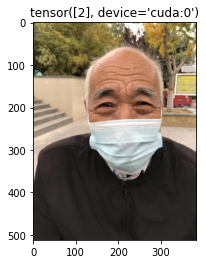

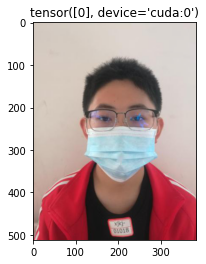

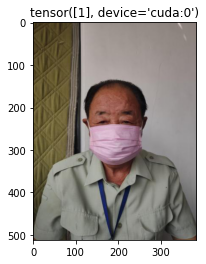

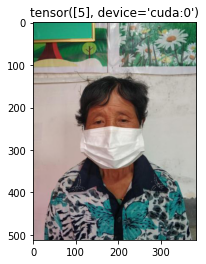

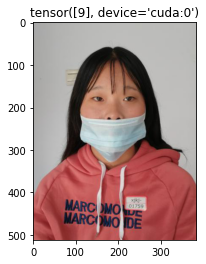

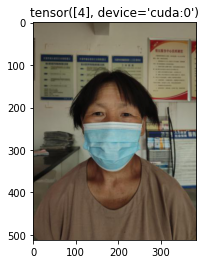

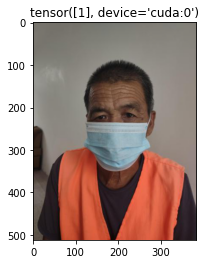

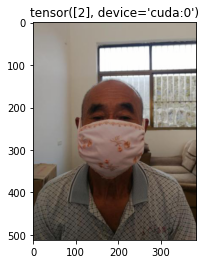

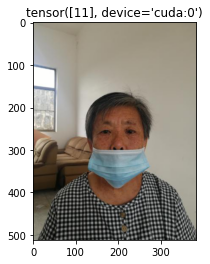

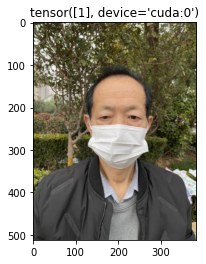

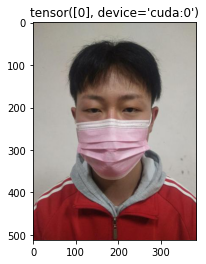

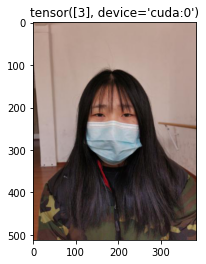

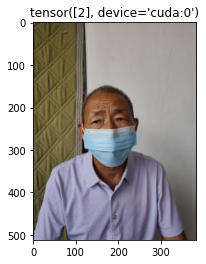

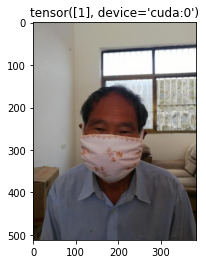

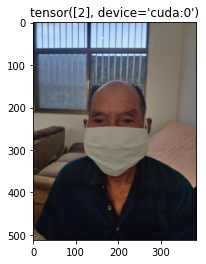

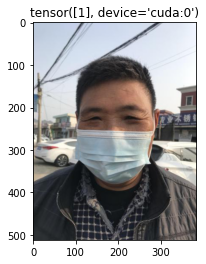

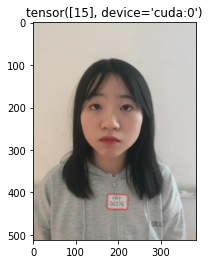

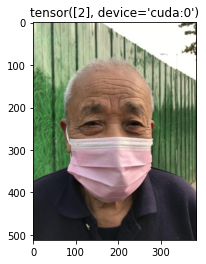

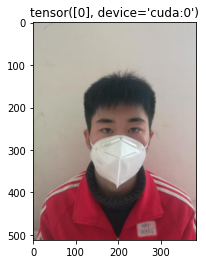

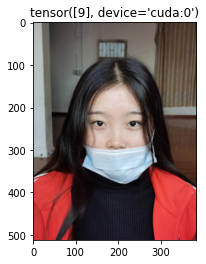

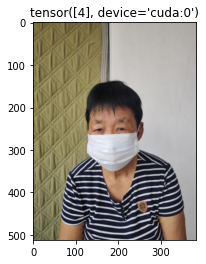

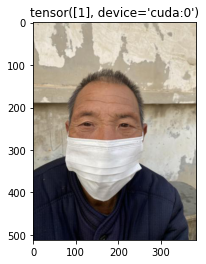

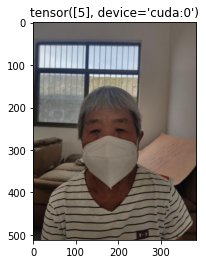

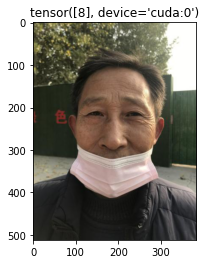

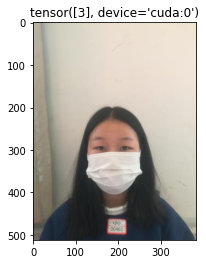

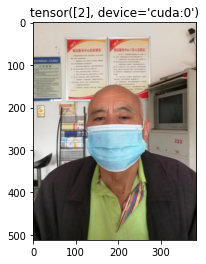

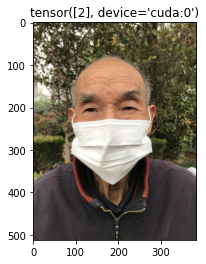

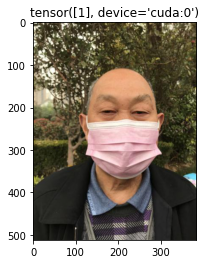

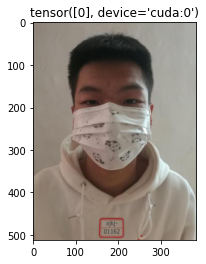

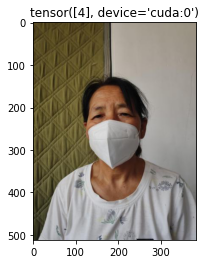

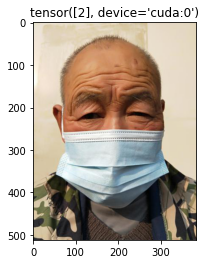

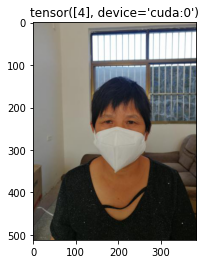

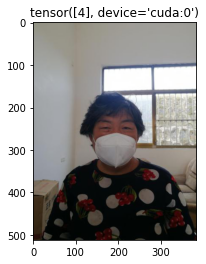

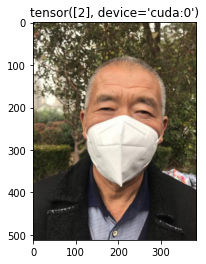

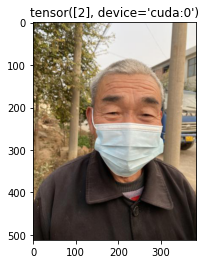

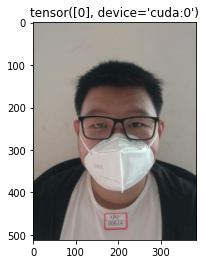

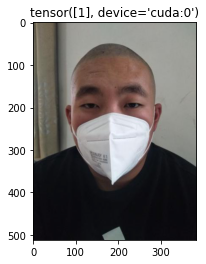

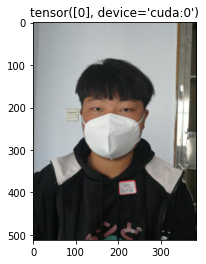

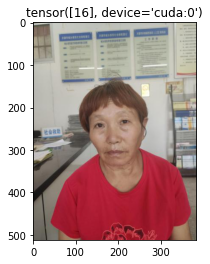

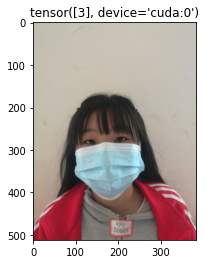

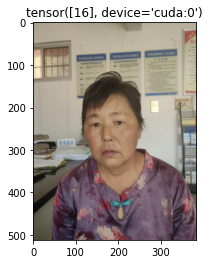

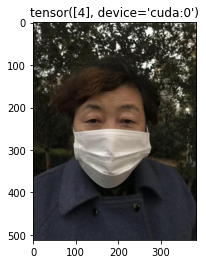

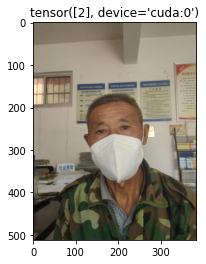

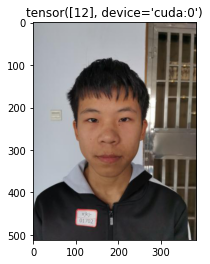

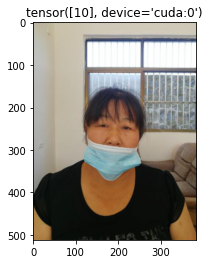

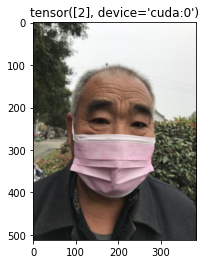

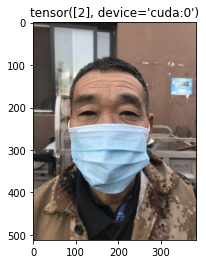

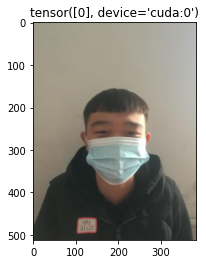

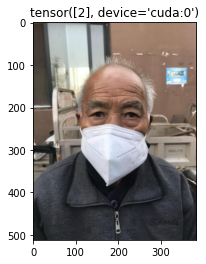

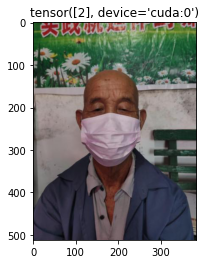

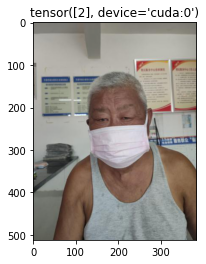

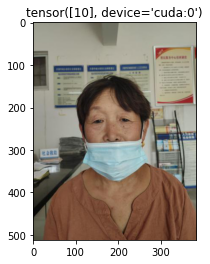

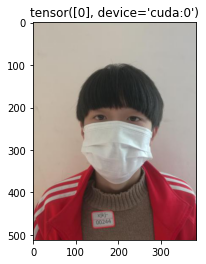

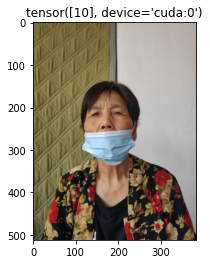

In [79]:
# Test gender model
model.eval()
start_time = time.time()
class_names = [0, 1]

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, inputs in enumerate(loader):
        inputs = inputs.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        images = torchvision.utils.make_grid(inputs)
        imshow(images.cpu(), title=preds)
            
        if i == 100:
            break

In [80]:
# combined model
model.eval()
all_predictions= []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.cpu().numpy()
        all_predictions.append(predicted)
        print(predicted)

[13]
[1]
[14]
[13]
[12]
[0]
[8]
[3]
[4]
[3]
[14]
[3]
[6]
[3]
[0]
[4]
[2]
[2]
[8]
[5]
[12]
[1]
[2]
[12]
[2]
[0]
[16]
[2]
[2]
[0]
[0]
[4]
[3]
[4]
[2]
[0]
[3]
[8]
[14]
[6]
[2]
[1]
[8]
[3]
[4]
[2]
[4]
[2]
[0]
[1]
[5]
[9]
[4]
[1]
[2]
[11]
[1]
[0]
[3]
[2]
[1]
[2]
[1]
[15]
[2]
[0]
[9]
[4]
[1]
[5]
[8]
[3]
[2]
[2]
[1]
[0]
[4]
[2]
[4]
[4]
[2]
[2]
[0]
[1]
[0]
[16]
[3]
[16]
[4]
[2]
[12]
[10]
[2]
[2]
[0]
[2]
[2]
[2]
[10]
[0]
[10]
[2]
[2]
[2]
[0]
[3]
[1]
[12]
[4]
[4]
[0]
[17]
[0]
[0]
[4]
[13]
[10]
[5]
[3]
[3]
[3]
[9]
[10]
[5]
[15]
[1]
[2]
[14]
[0]
[13]
[4]
[0]
[8]
[3]
[3]
[13]
[2]
[14]
[0]
[15]
[2]
[2]
[3]
[0]
[0]
[1]
[9]
[5]
[0]
[5]
[1]
[4]
[4]
[12]
[14]
[17]
[3]
[0]
[15]
[15]
[3]
[15]
[4]
[8]
[0]
[4]
[14]
[3]
[1]
[1]
[4]
[14]
[2]
[8]
[7]
[3]
[3]
[1]
[3]
[4]
[2]
[0]
[2]
[17]
[6]
[0]
[5]
[9]
[17]
[17]
[5]
[13]
[0]
[4]
[0]
[12]
[3]
[14]
[12]
[6]
[4]
[0]
[0]
[12]
[2]
[3]
[10]
[4]
[0]
[5]
[16]
[3]
[1]
[6]
[2]
[4]
[8]
[2]
[3]
[0]
[13]
[14]
[2]
[3]
[0]
[2]
[2]
[5]
[0]
[3]
[2]
[14]
[14]
[0]
[8]
[3]
[2]
[0

In [81]:
for i in range(len(all_predictions)):
    all_predictions[i] = int(all_predictions[i])

print(all_predictions[:5])
print(len(all_predictions))

[13, 1, 14, 13, 12]
12600


In [82]:
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!
